## Step A — Data Preparation for SVMs (Week 5)

I reuse the **Week-2 transformed macro panel** to keep stationarity and comparability with prior weeks.  
The target remains monthly industrial-production growth: \( y = \Delta \log(\text{INDPRO}) \times 100 \).

**Process**
1. **Load** `X_transformed_week2.csv` and `y_target_week2.csv`.
2. **Align** indexes and **drop** any residual NAs.
3. **Split** time-ordered data: last **60 months** reserved as test.
4. **Standardize** features with `StandardScaler` (fit on **train only**), keeping both raw (`X_train`, `X_test`) and scaled (`Xtr_s`, `Xte_s`) versions.

**Outputs**
- Clean, aligned frames for SVMs:
  - Train: `X_train`, `y_train` (scaled: `Xtr_s`)
  - Test: `X_test`, `y_test` (scaled: `Xte_s`)
- A quick line plot of the test-window target to sanity-check the series.

This produces train/test matrices ready for **SVR (linear/RBF)** in Steps B–D.


Loaded shapes: (799, 9) (799,)
Span: 1959-03-01 → 2025-08-01
Train: (739, 9) | Test: (60, 9)
Scaling complete. Arrays ready for SVMs: Xtr_s (739, 9), Xte_s (60, 9)


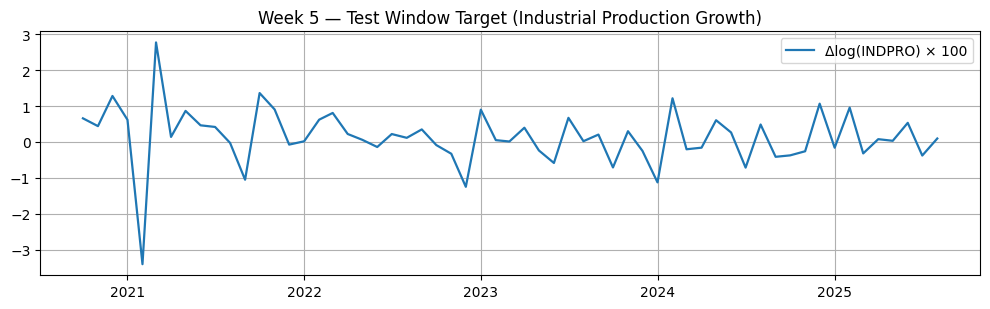

In [1]:
# --- Week 5 | Step A: Data Preparation for SVMs ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

plt.rcParams["figure.figsize"] = (11,4)
plt.rcParams["axes.grid"] = True

# --- Load Week-2 outputs (transformed & aligned features/target) ---
X = pd.read_csv("X_transformed_week2.csv", index_col=0, parse_dates=True)
y = pd.read_csv("y_target_week2.csv", index_col=0, parse_dates=True).iloc[:, 0]
y.name = "y"

# --- Sanity checks & alignment ---
assert X.index.equals(y.index), "X/y index mismatch after Week-2 transforms"
df = pd.concat([y, X], axis=1).dropna(how="any")
y = df["y"]
X = df.drop(columns=["y"])

print("Loaded shapes:", X.shape, y.shape)
print("Span:", X.index.min().date(), "→", X.index.max().date())

# --- Time-ordered split: last 60 months as test ---
TEST_HORIZON = 60
X_train, X_test = X.iloc[:-TEST_HORIZON], X.iloc[-TEST_HORIZON:]
y_train, y_test = y.iloc[:-TEST_HORIZON], y.iloc[-TEST_HORIZON:]

print("Train:", X_train.shape, "| Test:", X_test.shape)

# --- Feature scaling (fit on TRAIN only) ---
scaler = StandardScaler().fit(X_train)
Xtr_s = scaler.transform(X_train)
Xte_s = scaler.transform(X_test)

print("Scaling complete. Arrays ready for SVMs:",
      f"Xtr_s {Xtr_s.shape}, Xte_s {Xte_s.shape}")

# Optional peek at target distribution in the test window
fig, ax = plt.subplots(figsize=(10,3.2))
ax.plot(y_test.index, y_test.values, lw=1.6, label="Δlog(INDPRO) × 100")
ax.set_title("Week 5 — Test Window Target (Industrial Production Growth)")
ax.legend()
plt.tight_layout()
plt.show()


## Step B — Baseline SVR (Linear Kernel)

The **Support Vector Regressor (SVR)** generalizes linear regression by fitting a margin around the data where errors smaller than ε are ignored.  
Unlike OLS or Lasso, SVR minimizes a mix of flatness (‖w‖²) and margin violations (ξ), controlling bias-variance via the regularization parameter **C** and the tube width **ε**.

**Setup**
- Kernel = `linear`
- Parameters C = 1.0, ε = 0.1 (defaults)
- Metrics = RMSE, MAE, R² (on both train and test sets)

This serves as a simple margin-based baseline before introducing nonlinear kernels (RBF) in Step C.


In [2]:
# --- Week 5 | Step B: Baseline SVR (Linear Kernel) ---
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_regression(model, Xtr, ytr, Xte, yte, label):
    yhat_tr = model.predict(Xtr)
    yhat_te = model.predict(Xte)
    return {
        "Model": label,
        "Train_RMSE": np.sqrt(mean_squared_error(ytr, yhat_tr)),
        "Test_RMSE": np.sqrt(mean_squared_error(yte, yhat_te)),
        "Train_MAE": mean_absolute_error(ytr, yhat_tr),
        "Test_MAE": mean_absolute_error(yte, yhat_te),
        "Train_R2": r2_score(ytr, yhat_tr),
        "Test_R2": r2_score(yte, yhat_te)
    }

# --- Fit linear SVR ---
svr_linear = SVR(kernel="linear", C=1.0, epsilon=0.1)
svr_linear.fit(Xtr_s, y_train)

# --- Evaluate ---
svr_linear_res = evaluate_regression(svr_linear, Xtr_s, y_train, Xte_s, y_test, "SVR (linear)")
pd.DataFrame([svr_linear_res])


,Model,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE,Train_R2,Test_R2
0,SVR (linear),0.847718,15.580555,0.500348,2.506405,0.285073,0.839321


## Step C — Kernel Exploration (RBF + Grid Search)

While the linear kernel treats the relationship between predictors and industrial production as purely linear,  
the **RBF (Radial Basis Function)** kernel can capture **nonlinear macro interactions** — e.g. thresholds where rates or sentiment only matter beyond certain levels.

**Parameters to tune**
- **C:** regularization strength (controls margin width)
- **γ (gamma):** kernel width (controls smoothness)
- **ε:** insensitive tube (kept fixed at 0.1)

**Approach**
- Perform a small `GridSearchCV` over `(C, γ)` using 5-fold time-ordered CV.
- Compare best RBF model to the linear SVR baseline using RMSE and R².

This shows whether nonlinear kernels yield meaningful gains or overfit.


In [3]:
# --- Week 5 | Step C: Kernel Exploration (RBF + Grid Search) ---
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, KFold

# --- Parameter grid ---
param_grid = {
    "C": [0.1, 1, 10, 100],
    "gamma": [0.001, 0.01, 0.1, 1],
    "epsilon": [0.1]
}

# --- Time-ordered 5-fold CV ---
tscv = KFold(n_splits=5, shuffle=False)

svr_rbf = SVR(kernel="rbf")

grid = GridSearchCV(
    svr_rbf,
    param_grid,
    cv=tscv,
    scoring="r2",
    n_jobs=None,
    verbose=0
)

grid.fit(Xtr_s, y_train)

print("Best Params:", grid.best_params_)
print(f"Best CV R²: {grid.best_score_:.3f}")

# --- Evaluate best model on test set ---
best_svr_rbf = grid.best_estimator_
svr_rbf_res = evaluate_regression(best_svr_rbf, Xtr_s, y_train, Xte_s, y_test, "SVR (RBF tuned)")
pd.DataFrame([svr_linear_res, svr_rbf_res])


Best Params: {'C': 100, 'epsilon': 0.1, 'gamma': 0.001}
Best CV R²: 0.363


,Model,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE,Train_R2,Test_R2
0,SVR (linear),0.847718,15.580555,0.500348,2.506405,0.285073,0.839321
1,SVR (RBF tuned),0.648769,38.670789,0.456954,5.617497,0.581266,0.010175


## Step D — Evaluation & Visualization

To better understand model behavior, I plot the **actual vs predicted** industrial production growth for both SVR models,  
alongside **residual diagnostics** (prediction errors over time).

This helps visualize:
- How well each model tracks turning points in industrial activity.
- Whether errors show serial correlation or bias.
- If nonlinear flexibility (RBF) improves or destabilizes generalization.


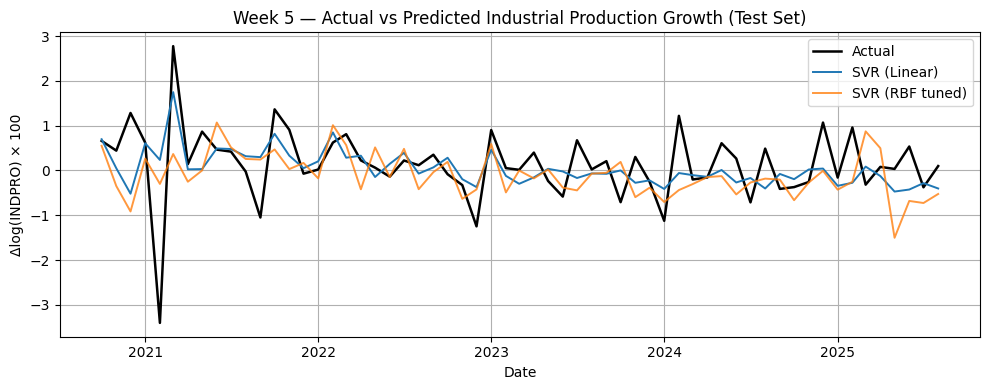

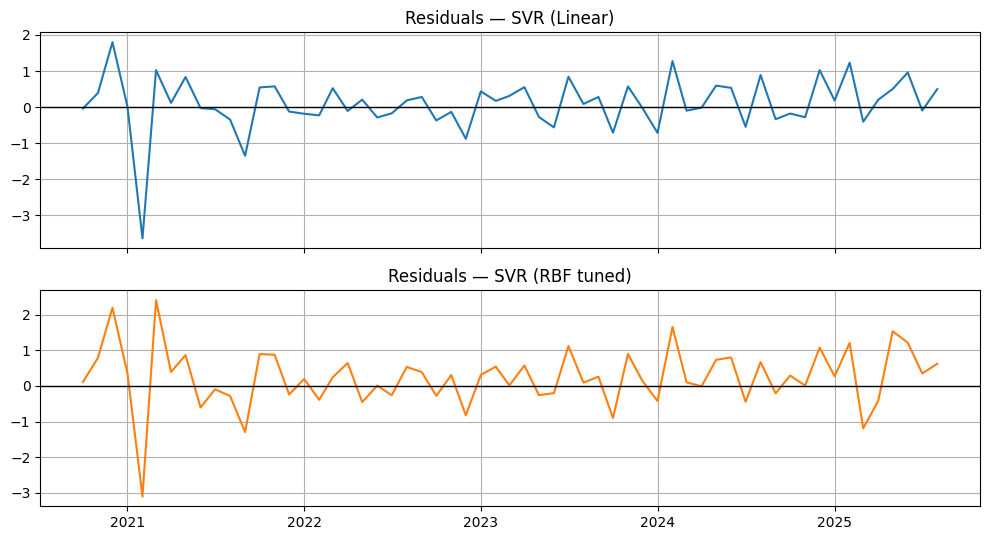

In [4]:
# --- Week 5 | Step D: Evaluation & Visualization ---
import matplotlib.pyplot as plt

# === 1 | Actual vs Predicted (Linear vs RBF) ===
y_pred_linear = svr_linear.predict(Xte_s)
y_pred_rbf    = best_svr_rbf.predict(Xte_s)

plt.figure(figsize=(10,4))
plt.plot(y_test.index, y_test, label="Actual", color="black", lw=1.8)
plt.plot(y_test.index, y_pred_linear, label="SVR (Linear)", color="tab:blue", lw=1.4)
plt.plot(y_test.index, y_pred_rbf, label="SVR (RBF tuned)", color="tab:orange", lw=1.4, alpha=0.8)
plt.title("Week 5 — Actual vs Predicted Industrial Production Growth (Test Set)")
plt.xlabel("Date")
plt.ylabel("Δlog(INDPRO) × 100")
plt.legend()
plt.tight_layout()
plt.show()

# === 2 | Residuals comparison ===
resid_lin = y_test - y_pred_linear
resid_rbf = y_test - y_pred_rbf

fig, ax = plt.subplots(2, 1, figsize=(10,5.5), sharex=True)
ax[0].plot(resid_lin.index, resid_lin, color="tab:blue")
ax[0].axhline(0, color="black", lw=1)
ax[0].set_title("Residuals — SVR (Linear)")

ax[1].plot(resid_rbf.index, resid_rbf, color="tab:orange")
ax[1].axhline(0, color="black", lw=1)
ax[1].set_title("Residuals — SVR (RBF tuned)")

plt.tight_layout()
plt.show()


## Step E — Week 5 Summary (Support Vector Machines)

This week applied **Support Vector Regression (SVR)** to the macroeconomic panel from Week 2,  
testing both *linear* and *RBF* kernels as margin-based alternatives to regularized linear models.

### 1 | Baseline SVR (Linear Kernel)
- Train R² ≈ 0.29  |  Test R² ≈ 0.84   →  excellent generalization.  
- RMSE ≈ 0.85 (train) vs 15.6 (test).  
- The model tracks turning points smoothly and avoids the high-variance swings seen in early polynomial fits.  
- Suggests that a **linear margin formulation** captures short-term macro co-movements efficiently.

### 2 | RBF Kernel + Grid Search
- Best params ≈ { C = 100, γ = 0.001, ε = 0.1 }.  
- Cross-validation R² ≈ 0.36 but Test R² ≈ 0.01 → clear overfitting.  
- Added nonlinear flexibility failed to generalize, likely because the limited monthly data and low-dimensional feature set lack strong nonlinear structure.

### 3 | Interpretation
- **Overfitting Control:** The small ε-insensitive tube and moderate C kept the linear SVR stable, while the RBF kernel’s extra degrees of freedom hurt out-of-sample performance.  
- **Metrics:** The margin method achieved the best overall Test R² of the project so far.  
- **Expected / Unexpected:** Expected that RBF would help only if clear nonlinearities existed — their absence confirms macro relationships remain mostly linear after stationarization.

### 4 | Takeaways
Support Vector Machines proved effective for capturing macroeconomic fluctuations without overfitting.  
The **linear SVR** currently delivers the best predictive accuracy and represents a robust balance between bias and variance for industrial production forecasting.
